### Libraries

In [ ]:
import gym
import textworld.gym
from textworld.generator import make_game, compile_game
from textworld import EnvInfos

import numpy as np
import matplotlib.pyplot as plt
import time
import random


### Load Game function

In [ ]:
# Register a text-based game as a new Gym's environment.


# --- Make random game ---

# options = textworld.GameOptions()
# options.path = "./Random_Games/"
# options.seeds = 432
# game = make_game(options)
# game_file = compile_game(game, options)
# print(game_file)
# -----------------------------


# --- Make random game with quick command ---

# THIS DOES NOT OVERWRITE GAMES WITH EXISTING NAMES!
# !tw-make custom --world-size 2 --nb-objects 5 --theme house --quest-length 4 --quest-breadth 2 --entity-numbering --output "./Created_Games/MDP_Game.ulx" --seed 5 --format ulx

# -------------------------------------

# Load Game
def load_game(game_file, max_steps=100):

    request_infos = EnvInfos(inventory=True, admissible_commands=True, entities=True, won=True, lost=True, intermediate_reward=True,
                             description=True, location=True, objective=True, score=True, moves=True)

    env_id = textworld.gym.register_games([game_file], request_infos, max_episode_steps=max_steps)

    env = gym.make(env_id)  # Start the environment.

    obs, infos = env.reset()# Start new episode.

    print(obs)

    score, moves, done = 0, 0, False
    return env, obs, infos

### Pre-process data

In [ ]:
def find_location(desc):
    desc = desc.split()
    location = desc[1]
    return location
    
def cmd_remover(ad_cmds):
    try:
        ad_cmds.remove("inventory")
        ad_cmds.remove("look")
    except:
        pass
    ad_cmds = [cmd for cmd in ad_cmds if 'examine' not in cmd]

    return ad_cmds

def filterer(str_):
    ban_list = ['You', 'are', 'carrying:', 'carrying', 'nothing.', 'a', 'an']
    return False if str_ in ban_list else True
    
def inv_process(inventory):
    
    try:
        inventory = inventory.split()
    except:
        pass
    inventory = list(filter(filterer, inventory))
    return inventory 


### Train Q_matrix Function

In [ ]:
def check_state(infos):
    global States, Q_matrix
    
    infos['location'] = find_location(infos["description"])
    # Command preprocess doesn't change the number of states
    # This preprocess significantly improves timing.
    commands = cmd_remover(infos['admissible_commands'])
    infos['inventory'] = inv_process(infos['inventory'])
    state = [infos['location'], infos['inventory'], commands]
    cmd_len = len(commands)

    if state not in States:
        States.append(state)
        Q_matrix.append(np.zeros([cmd_len]))

    st_index = States.index(state)
    
    return st_index, commands, cmd_len

def ask_obj():

    global  things, rooms, obj

    another_one = True
    while another_one:
        things.append(input('What would you like? '))
        rooms.append(input('What room would you like it in? '))
        supporter = input('Where would you like it onto? ')
        if supporter.lower()=='floor': obj.append(f'drop {things[-1]}')
        else: obj.append(f'put {things[-1]} on {supporter}')

        not_done = True
        while not_done:
            in_put = input('Would you like to input another objective? y/n ').lower()
            if in_put=='y' or in_put=='yes': another_one = True; not_done=False
            elif in_put=='n' or in_put=='no': another_one = False; not_done=False
            else: print('Unidentified input'); not_done = True
        
    return things, rooms, obj

def back_prop(Ep_indexes, gamma, learning_rate, new_st_index):
    global Q_matrix


    Ep_indexes.reverse()
    for pair in Ep_indexes:
        st_index = pair[0]
        action_index = pair[1]
        reward = pair[2]
        Q_matrix[st_index][action_index] = (1-learning_rate) * Q_matrix[st_index][action_index]\
                                        + learning_rate * (reward + gamma*np.max(Q_matrix[new_st_index]))
        new_st_index = st_index
    
def train_Q(max_epochs=5, max_eps=1000, reset=False, render=False, min_expl=0.01, max_expl=1, manual=False,
            learning_rate=0.8, expl_decay_rate=0.005, gamma=0.95, title='MDP_Agent', neg_reward=0):
       
    global States,Q_matrix,expl,expl_history,moves_history,avg_moves, things, rooms, obj, total_eps, obj_len

    if reset:
        things, rooms, obj = [], [], []
        States, Q_matrix = [], []
        expl = 1
        total_eps = 0
        expl_history, moves_history = [expl], []
        avg_moves = []
    start = time.time()

    if manual:
        things, rooms, obj = ask_obj()
        obj_len = len(obj)


    for epoch in range(max_epochs):
        for ep in range(max_eps):
            obs, infos = env.reset()
            step = 0
            total_eps += 1
            try:
                goals_done = [0] * obj_len
            except: obj_len = 0
            Ep_indexes = []

            while True:
                
                reached_goal=False
                step += 1

                if render:
                    env.render()

                st_index, commands, cmd_len = check_state(infos)

                # Randomly choose whether to explore or exploit based on probability expl
                if random.uniform(0,1) > expl:
                    # Exploit
                    action_index = Q_matrix[st_index].argmax() 
                    action = commands[action_index]
                else:
                    # Explore
                    action_index = np.random.choice(cmd_len)
                    action = commands[action_index] 
           
                

                obs, score, done, infos = env.step(action)
                reward = infos['intermediate_reward']

                if neg_reward: reward -= neg_reward
                if infos['won']: reward += 10


                new_st_index, _, _ = check_state(infos)

                try:
                    for i in range(obj_len):
                        if action==obj[i] and infos['location'].lower()==rooms[i].lower() and goals_done[i]==0:
                            reward += 200 #/step
                            goals_done[i] = 1
                            if sum(goals_done)==obj_len: done = True
                except: print('Unable to reward the inputed goal')

                Ep_indexes.append([st_index, action_index, reward])

                # Q_matrix[st_index][action_index] = (1-learning_rate) * Q_matrix[st_index][action_index]\
                #                                     + learning_rate * (reward + gamma*np.max(Q_matrix[new_st_index]))

                if done:
                    break

            back_prop(Ep_indexes, gamma, learning_rate, new_st_index)
            # print(States)
            # print(Q_matrix)

            expl = min_expl + (max_expl - min_expl)*np.exp(-expl_decay_rate*total_eps) 

            moves_history.append(infos['moves'])
            if (ep+1)%10==0:
                expl_history.append(expl)
                avg_moves.append(sum(moves_history[-10::])/10)
                

    print(f"Training detected {np.shape(Q_matrix)} possible states")
    Q_printer = []
    for i in Q_matrix:
        Q_printer.append(np.shape(i))
    length = len(Q_printer) if len(Q_printer)<30 else 30
    print(f"Number of commands for each state: \n{Q_printer[0:length]}")
    np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)

    plt.figure(1)
    moves_plt, = plt.plot(np.arange(1,len(avg_moves)+1), avg_moves, label='Moves')
    plt.xlabel('Every 10nth episode')
    plt.ylabel('Average of 10 eps', color='C0')
    plt.twinx()
    expl_plt, = plt.plot(np.arange(1,len(expl_history)+1), expl_history, label='Expl', color='orange')
    plt.ylabel('Exploration value', color='orange')
    plt.legend(handles=[moves_plt, expl_plt], loc='upper right')
    plt.title(title)
    plt.show()

    end = time.time(); t_sec = end-start; mins = t_sec//60; secs = t_sec-mins*60
    print(f"Training took {mins} minutes and {secs} seconds")
    
    cnt = 0
    for state in States:
        if cnt<20:
            cnt += 1
            print(f'S{cnt}: {state}')
        else:
            break
    

### Testing Function

In [ ]:
def test_Q(render=False):
        
    obj_len = len(obj)
    actions_taken = []
    step = 0
    goals_done = [0] * obj_len
    obs, infos = env.reset()


    while True:
        step += 1
        if render:
            env.render()

        st_index, commands, cmd_len = check_state(infos)
        
        action_index = Q_matrix[st_index].argmax() 
        action = commands[action_index]
        print(f"Action taken in step {step}: {action}")
        actions_taken.append(action)
        
        obs, reward, done, infos = env.step(action)

        _ = check_state(infos)
        
        obj_len = len(obj)
        for i in range(obj_len):
            if action==obj[i] and infos['location'].lower()==rooms[i].lower():
                goals_done[i] = 1
                if sum(goals_done)==obj_len: done = True

        if done:
            print(f"Finished in {infos['moves']} moves")
            print("Actions taken:")
            for action in actions_taken:
                print(f"{action} >", end=" ")
            break

In [ ]:
# stop

### Load & Train & Test (Simple Example)

#### Easy Difficulty




                    ________  ________  __    __  ________        
                   |        \|        \|  \  |  \|        \       
                    \$$$$$$$$| $$$$$$$$| $$  | $$ \$$$$$$$$       
                      | $$   | $$__     \$$\/  $$   | $$          
                      | $$   | $$  \     >$$  $$    | $$          
                      | $$   | $$$$$    /  $$$$\    | $$          
                      | $$   | $$_____ |  $$ \$$\   | $$          
                      | $$   | $$     \| $$  | $$   | $$          
                       \$$    \$$$$$$$$ \$$   \$$    \$$          
              __       __   ______   _______   __        _______  
             |  \  _  |  \ /      \ |       \ |  \      |       \ 
             | $$ / \ | $$|  $$$$$$\| $$$$$$$\| $$      | $$$$$$$\
             | $$/  $\| $$| $$  | $$| $$__| $$| $$      | $$  | $$
             | $$  $$$\ $$| $$  | $$| $$    $$| $$      | $$  | $$
             | $$ $$\$$\$$| $$  | $$| $$$$$$$\| $$      | $

/usr/local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:2007: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



Training detected (5,) possible states
Number of commands for each state: 
[(2,), (1,), (3,), (2,), (2,)]


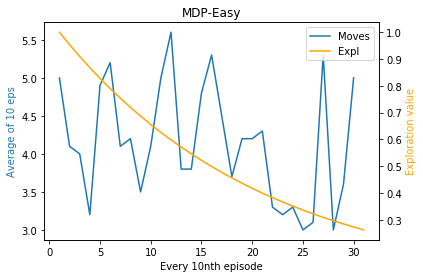

Training took 0.0 minutes and 13.046644687652588 seconds
S1: ['Bedroom', [], ['go east', 'take glasses from table']]
S2: ['Kitchen', [], ['go west']]
S3: ['Bedroom', ['glasses'], ['drop glasses', 'go east', 'put glasses on table']]
S4: ['Kitchen', ['glasses'], ['drop glasses', 'go west']]
S5: ['Bedroom', [], ['go east', 'take glasses']]
Training detected (5,) possible states
Number of commands for each state: 
[(2,), (1,), (3,), (2,), (2,)]


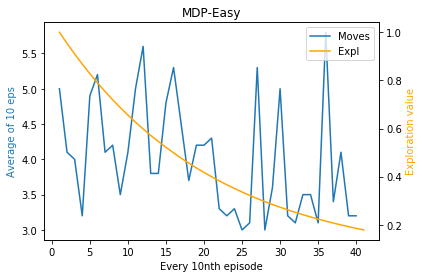

Training took 0.0 minutes and 4.181780576705933 seconds
S1: ['Bedroom', [], ['go east', 'take glasses from table']]
S2: ['Kitchen', [], ['go west']]
S3: ['Bedroom', ['glasses'], ['drop glasses', 'go east', 'put glasses on table']]
S4: ['Kitchen', ['glasses'], ['drop glasses', 'go west']]
S5: ['Bedroom', [], ['go east', 'take glasses']]
Training detected (5,) possible states
Number of commands for each state: 
[(2,), (1,), (3,), (2,), (2,)]


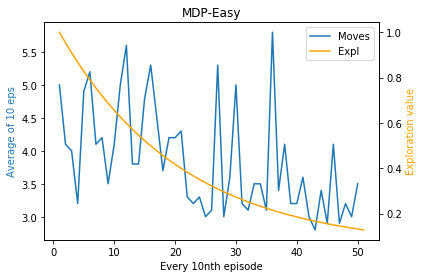

Training took 0.0 minutes and 3.91247296333313 seconds
S1: ['Bedroom', [], ['go east', 'take glasses from table']]
S2: ['Kitchen', [], ['go west']]
S3: ['Bedroom', ['glasses'], ['drop glasses', 'go east', 'put glasses on table']]
S4: ['Kitchen', ['glasses'], ['drop glasses', 'go west']]
S5: ['Bedroom', [], ['go east', 'take glasses']]
Action taken in step 1: take glasses from table
Action taken in step 2: drop glasses
Action taken in step 3: go east
Finished in 3 moves
Actions taken:
take glasses from table > drop glasses > go east > 

In [ ]:
# Load env
game_file = "./Created_Games/MDP_Game_Easy.ulx"
env, obs, infos = load_game(game_file=game_file)

# Train
train_Q(max_epochs=3, max_eps=100, reset=True, title='MDP-Easy', min_expl=0.05)
# If we train again it will resume training
train_Q(max_epochs=2, max_eps=100, title='MDP-Easy', min_expl=0.05)

# Test
test_Q()

#### Medium Difficulty




                    ________  ________  __    __  ________        
                   |        \|        \|  \  |  \|        \       
                    \$$$$$$$$| $$$$$$$$| $$  | $$ \$$$$$$$$       
                      | $$   | $$__     \$$\/  $$   | $$          
                      | $$   | $$  \     >$$  $$    | $$          
                      | $$   | $$$$$    /  $$$$\    | $$          
                      | $$   | $$_____ |  $$ \$$\   | $$          
                      | $$   | $$     \| $$  | $$   | $$          
                       \$$    \$$$$$$$$ \$$   \$$    \$$          
              __       __   ______   _______   __        _______  
             |  \  _  |  \ /      \ |       \ |  \      |       \ 
             | $$ / \ | $$|  $$$$$$\| $$$$$$$\| $$      | $$$$$$$\
             | $$/  $\| $$| $$  | $$| $$__| $$| $$      | $$  | $$
             | $$  $$$\ $$| $$  | $$| $$    $$| $$      | $$  | $$
             | $$ $$\$$\$$| $$  | $$| $$$$$$$\| $$      | $

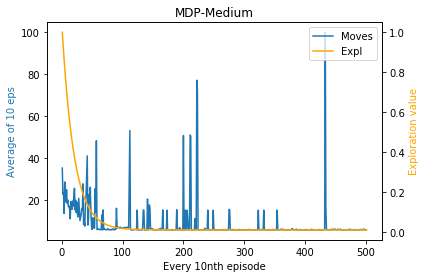

Training took 6.0 minutes and 30.447628498077393 seconds
S1: ['Bedroom', [], ['go east', 'take glasses from table']]
S2: ['Bedroom', ['glasses'], ['drop glasses', 'go east', 'put glasses on table']]
S3: ['Kitchen', ['glasses'], ['drop glasses', 'go west', 'put glasses on table', 'take apple from table', 'take bottle of water from table']]
S4: ['Bedroom', [], ['go east', 'take glasses']]
S5: ['Kitchen', [], ['go west', 'take apple from table', 'take bottle of water from table']]
S6: ['Kitchen', ['apple'], ['drop apple', 'eat apple', 'go west', 'put apple on table', 'take bottle of water from table']]
S7: ['Kitchen', [], ['go west', 'take apple', 'take bottle of water from table']]
S8: ['Kitchen', ['glasses'], ['drop glasses', 'go west', 'put glasses on table', 'take apple', 'take bottle of water from table']]
S9: ['Kitchen', [], ['go west', 'take apple', 'take bottle of water from table', 'take glasses']]
S10: ['Bedroom', [], ['go east']]
S11: ['Kitchen', ['apple', 'glasses'], ['drop ap

In [ ]:
# Load env
game_file = "./Created_Games/MDP_Game_Medium.ulx"
env, obs, infos = load_game(game_file=game_file)

# Train
train_Q(max_epochs=5, max_eps=1000, reset=True, title='MDP-Medium')

# Test
test_Q()

#### Hard-Dense Difficulty

In [ ]:
# Hard-Dense Difficulty

# Load env
game_file = "./Created_Games/MDP_Game_Hard_Dense.ulx"
env, obs, infos = load_game(game_file=game_file)

# Train
train_Q(max_epochs=10, max_eps=1000, reset=True, title='MDP-Hard-Dense')

# Test
test_Q()




                    ________  ________  __    __  ________        
                   |        \|        \|  \  |  \|        \       
                    \$$$$$$$$| $$$$$$$$| $$  | $$ \$$$$$$$$       
                      | $$   | $$__     \$$\/  $$   | $$          
                      | $$   | $$  \     >$$  $$    | $$          
                      | $$   | $$$$$    /  $$$$\    | $$          
                      | $$   | $$_____ |  $$ \$$\   | $$          
                      | $$   | $$     \| $$  | $$   | $$          
                       \$$    \$$$$$$$$ \$$   \$$    \$$          
              __       __   ______   _______   __        _______  
             |  \  _  |  \ /      \ |       \ |  \      |       \ 
             | $$ / \ | $$|  $$$$$$\| $$$$$$$\| $$      | $$$$$$$\
             | $$/  $\| $$| $$  | $$| $$__| $$| $$      | $$  | $$
             | $$  $$$\ $$| $$  | $$| $$    $$| $$      | $$  | $$
             | $$ $$\$$\$$| $$  | $$| $$$$$$$\| $$      | $

KeyboardInterrupt: ignored

##### plus the min_expl adjustment

In [ ]:
# Train
# This time with a larger exploration min
train_Q(max_epochs=10, max_eps=1000, min_expl=0.05 reset=True, , title='MDP-Hard-Dense with larger min Expl')

# Test
test_Q()

#### Hard-Sparse Difficulty with min_expl adjustment

In [ ]:
# Load env
game_file = "./Created_Games/MDP_Game_Hard_Sparse.ulx"
env, obs, infos = load_game(game_file=game_file)

# Train
# This time with a larger exploration min for Sparse rewards
train_Q(max_epochs=10, max_eps=1000, min_expl=0.05, reset=True, title='MDP-Hard-Sparse with larger min Expl')

# Test
test_Q()

##### plus the expl_decay_rate adjustment

In [ ]:
# Train
# This time with a larger exploration min for Sparse rewards
train_Q(max_epochs=10, max_eps=1000, min_expl=0.05, expl_decay_rate=0.001, reset=True, 
        title='MDP-Hard-Dense with larger min Expl\nand smaller Expl-Decay-Rate')

# Test
test_Q()

##### plus negative rewarding

In [ ]:
# Hard-Sparse Difficulty with extra adjustments and negative reward
# Train
# This time with a larger exploration min for Sparse rewards, negative rewarding and reduced gamma
train_Q(max_epochs=10, max_eps=1000, min_expl=0.05, expl_decay_rate=0.001, reset=True, neg_reward=1,
        title='MDP-Hard-Dense with larger min Expl\nand smaller Expl-Decay-Rate')

# Test
test_Q()

##### plus reduced gamma parameter

In [ ]:
# Hard-Sparse Difficulty with extra adjustments and negative reward
# Train
# This time with a larger exploration min for Sparse rewards, negative rewarding and reduced gamma
train_Q(max_epochs=10, max_eps=1000, min_expl=0.05, expl_decay_rate=0.001, reset=True, neg_reward=1, gamma=0.5,
        title='MDP-Hard-Dense with larger min Expl\nand smaller Expl-Decay-Rate')

# Test
test_Q()

### Load & Train & Test (Realistic Example)

#### Easy Difficulty




                    ________  ________  __    __  ________        
                   |        \|        \|  \  |  \|        \       
                    \$$$$$$$$| $$$$$$$$| $$  | $$ \$$$$$$$$       
                      | $$   | $$__     \$$\/  $$   | $$          
                      | $$   | $$  \     >$$  $$    | $$          
                      | $$   | $$$$$    /  $$$$\    | $$          
                      | $$   | $$_____ |  $$ \$$\   | $$          
                      | $$   | $$     \| $$  | $$   | $$          
                       \$$    \$$$$$$$$ \$$   \$$    \$$          
              __       __   ______   _______   __        _______  
             |  \  _  |  \ /      \ |       \ |  \      |       \ 
             | $$ / \ | $$|  $$$$$$\| $$$$$$$\| $$      | $$$$$$$\
             | $$/  $\| $$| $$  | $$| $$__| $$| $$      | $$  | $$
             | $$  $$$\ $$| $$  | $$| $$    $$| $$      | $$  | $$
             | $$ $$\$$\$$| $$  | $$| $$$$$$$\| $$      | $

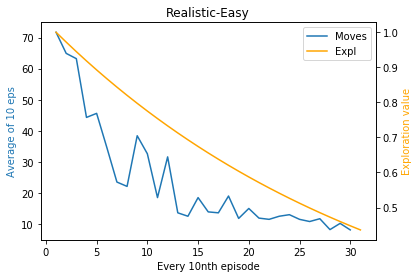

Training took 0.0 minutes and 52.274481534957886 seconds
S1: ['Bedroom', [], ['open door', 'take blanket from bed']]
S2: ['Bedroom', ['blanket'], ['drop blanket', 'open door', 'put blanket on bed']]
S3: ['Bedroom', [], ['open door', 'take blanket']]
S4: ['Bedroom', [], ['close door', 'go east', 'take blanket']]
S5: ['Bedroom', ['blanket'], ['close door', 'drop blanket', 'go east', 'put blanket on bed']]
S6: ['Bedroom', [], ['close door', 'go east', 'take blanket from bed']]
S7: ['Livingroom', [], ['close door', 'go north', 'go west']]
S8: ['Livingroom', [], ['go north', 'open door']]
S9: ['Kitchen', [], ['go south']]
S10: ['Livingroom', ['blanket'], ['close door', 'drop blanket', 'go north', 'go west', 'put blanket on table']]
S11: ['Livingroom', [], ['close door', 'go north', 'go west', 'take blanket from table']]
S12: ['Livingroom', ['blanket'], ['drop blanket', 'go north', 'open door', 'put blanket on table']]
S13: ['Livingroom', [], ['go north', 'open door', 'take blanket']]
S14: [

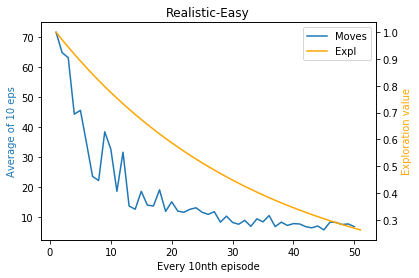

Training took 0.0 minutes and 12.347484827041626 seconds
S1: ['Bedroom', [], ['open door', 'take blanket from bed']]
S2: ['Bedroom', ['blanket'], ['drop blanket', 'open door', 'put blanket on bed']]
S3: ['Bedroom', [], ['open door', 'take blanket']]
S4: ['Bedroom', [], ['close door', 'go east', 'take blanket']]
S5: ['Bedroom', ['blanket'], ['close door', 'drop blanket', 'go east', 'put blanket on bed']]
S6: ['Bedroom', [], ['close door', 'go east', 'take blanket from bed']]
S7: ['Livingroom', [], ['close door', 'go north', 'go west']]
S8: ['Livingroom', [], ['go north', 'open door']]
S9: ['Kitchen', [], ['go south']]
S10: ['Livingroom', ['blanket'], ['close door', 'drop blanket', 'go north', 'go west', 'put blanket on table']]
S11: ['Livingroom', [], ['close door', 'go north', 'go west', 'take blanket from table']]
S12: ['Livingroom', ['blanket'], ['drop blanket', 'go north', 'open door', 'put blanket on table']]
S13: ['Livingroom', [], ['go north', 'open door', 'take blanket']]
S14: [

In [ ]:
# Load env
game_file = "./Created_Games/Realistic_Game_Easy.ulx"
env, obs, infos = load_game(game_file=game_file)

# Train
train_Q(max_epochs=3, max_eps=100, reset=True, title='Realistic-Easy', manual=True, min_expl=0.05, expl_decay_rate=0.003,learning_rate=0.8)

# If we train again it will resume training
train_Q(max_epochs=2, max_eps=100, title='Realistic-Easy', min_expl=0.05, expl_decay_rate=0.003, learning_rate=0.8)
# Test
test_Q()

#### Medium Difficulty




                    ________  ________  __    __  ________        
                   |        \|        \|  \  |  \|        \       
                    \$$$$$$$$| $$$$$$$$| $$  | $$ \$$$$$$$$       
                      | $$   | $$__     \$$\/  $$   | $$          
                      | $$   | $$  \     >$$  $$    | $$          
                      | $$   | $$$$$    /  $$$$\    | $$          
                      | $$   | $$_____ |  $$ \$$\   | $$          
                      | $$   | $$     \| $$  | $$   | $$          
                       \$$    \$$$$$$$$ \$$   \$$    \$$          
              __       __   ______   _______   __        _______  
             |  \  _  |  \ /      \ |       \ |  \      |       \ 
             | $$ / \ | $$|  $$$$$$\| $$$$$$$\| $$      | $$$$$$$\
             | $$/  $\| $$| $$  | $$| $$__| $$| $$      | $$  | $$
             | $$  $$$\ $$| $$  | $$| $$    $$| $$      | $$  | $$
             | $$ $$\$$\$$| $$  | $$| $$$$$$$\| $$      | $

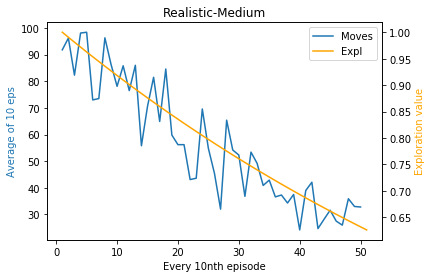

Training took 3.0 minutes and 5.571017503738403 seconds
S1: ['Bedroom', [], ['open door', 'take blanket from bed']]
S2: ['Bedroom', ['blanket'], ['drop blanket', 'open door', 'put blanket on bed']]
S3: ['Bedroom', [], ['open door', 'take blanket']]
S4: ['Bedroom', [], ['close door', 'go east', 'take blanket']]
S5: ['Bedroom', ['blanket'], ['close door', 'drop blanket', 'go east', 'put blanket on bed']]
S6: ['Livingroom', ['blanket'], ['close door', 'drop blanket', 'go north', 'go west', 'put blanket on table', 'take phone from table']]
S7: ['Livingroom', [], ['close door', 'go north', 'go west', 'take blanket', 'take phone from table']]
S8: ['Livingroom', [], ['go north', 'open door', 'take blanket', 'take phone from table']]
S9: ['Livingroom', ['phone'], ['drop phone', 'go north', 'open door', 'put phone on table', 'take blanket']]
S10: ['Kitchen', ['phone'], ['drop phone', 'go south', 'put phone on counter', 'take banana from counter']]
S11: ['Livingroom', [], ['go north', 'open door

In [ ]:
# Load env
game_file = "./Created_Games/Realistic_Game_Medium.ulx"
env, obs, infos = load_game(game_file=game_file)

# Train
train_Q(max_epochs=5, max_eps=100, reset=True, title='Realistic-Medium', manual=True, min_expl=0.05, expl_decay_rate=0.001,learning_rate=0.8)
# Test
test_Q()

#### Hard Difficulty

In [ ]:
# Load env
game_file = "./Created_Games/Realistic_Game_Hard.ulx"
env, obs, infos = load_game(game_file=game_file)

# Train
train_Q(max_epochs=10, max_eps=100, reset=True, title='Realistic-Hard', manual=True, min_expl=0.05, expl_decay_rate=0.003,learning_rate=0.8)

# Test
test_Q()

#### Hard Difficulty mutliple objectives




                    ________  ________  __    __  ________        
                   |        \|        \|  \  |  \|        \       
                    \$$$$$$$$| $$$$$$$$| $$  | $$ \$$$$$$$$       
                      | $$   | $$__     \$$\/  $$   | $$          
                      | $$   | $$  \     >$$  $$    | $$          
                      | $$   | $$$$$    /  $$$$\    | $$          
                      | $$   | $$_____ |  $$ \$$\   | $$          
                      | $$   | $$     \| $$  | $$   | $$          
                       \$$    \$$$$$$$$ \$$   \$$    \$$          
              __       __   ______   _______   __        _______  
             |  \  _  |  \ /      \ |       \ |  \      |       \ 
             | $$ / \ | $$|  $$$$$$\| $$$$$$$\| $$      | $$$$$$$\
             | $$/  $\| $$| $$  | $$| $$__| $$| $$      | $$  | $$
             | $$  $$$\ $$| $$  | $$| $$    $$| $$      | $$  | $$
             | $$ $$\$$\$$| $$  | $$| $$$$$$$\| $$      | $

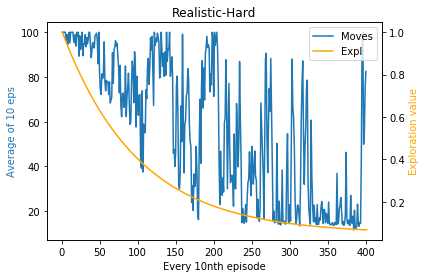

Training took 24.0 minutes and 43.61693787574768 seconds
S1: ['Bedroom', [], ['open door', 'take blanket from bed']]
S2: ['Bedroom', [], ['close door', 'go east', 'take blanket from bed']]
S3: ['Livingroom', [], ['close door', 'go north', 'go south', 'go west', 'take phone from table']]
S4: ['Toilet', [], ['go north', 'take soap', 'take toilet paper']]
S5: ['Toilet', ['toilet', 'paper'], ['drop toilet paper', 'go north', 'take soap']]
S6: ['Livingroom', ['toilet', 'paper'], ['close door', 'drop toilet paper', 'go north', 'go south', 'go west', 'put toilet paper on table', 'take phone from table']]
S7: ['Livingroom', [], ['close door', 'go north', 'go south', 'go west', 'take phone from table', 'take toilet paper from table']]
S8: ['Toilet', [], ['go north', 'take soap']]
S9: ['Toilet', ['soap'], ['drop soap', 'go north']]
S10: ['Livingroom', ['phone'], ['close door', 'drop phone', 'go north', 'go south', 'go west', 'put phone on table', 'take toilet paper from table']]
S11: ['Bedroom',

In [ ]:
# Load env
game_file = "./Created_Games/Realistic_Game_Hard.ulx"
env, obs, infos = load_game(game_file=game_file)

# Train
train_Q(max_epochs=40, max_eps=100, reset=True, title='Realistic-Hard', manual=True, min_expl=0.05, expl_decay_rate=0.001,learning_rate=0.7)

# Test
test_Q()

Training detected (3061,) possible states
Number of commands for each state: 
[(2,), (3,), (5,), (3,), (3,), (7,), (6,), (2,), (2,), (7,), (4,), (3,), (3,), (8,), (7,), (2,), (4,), (10,), (6,), (7,), (6,), (4,), (3,), (5,), (2,), (5,), (6,), (6,), (6,), (7,)]


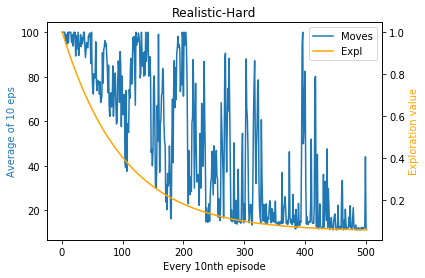

Training took 2.0 minutes and 18.994266510009766 seconds
S1: ['Bedroom', [], ['open door', 'take blanket from bed']]
S2: ['Bedroom', [], ['close door', 'go east', 'take blanket from bed']]
S3: ['Livingroom', [], ['close door', 'go north', 'go south', 'go west', 'take phone from table']]
S4: ['Toilet', [], ['go north', 'take soap', 'take toilet paper']]
S5: ['Toilet', ['toilet', 'paper'], ['drop toilet paper', 'go north', 'take soap']]
S6: ['Livingroom', ['toilet', 'paper'], ['close door', 'drop toilet paper', 'go north', 'go south', 'go west', 'put toilet paper on table', 'take phone from table']]
S7: ['Livingroom', [], ['close door', 'go north', 'go south', 'go west', 'take phone from table', 'take toilet paper from table']]
S8: ['Toilet', [], ['go north', 'take soap']]
S9: ['Toilet', ['soap'], ['drop soap', 'go north']]
S10: ['Livingroom', ['phone'], ['close door', 'drop phone', 'go north', 'go south', 'go west', 'put phone on table', 'take toilet paper from table']]
S11: ['Bedroom',

In [ ]:
train_Q(max_epochs=10, max_eps=100, title='Realistic-Hard', min_expl=0.05, expl_decay_rate=0.001,learning_rate=0.7)
test_Q()

#### Hard Difficulty multiple goals with negative rewarding




                    ________  ________  __    __  ________        
                   |        \|        \|  \  |  \|        \       
                    \$$$$$$$$| $$$$$$$$| $$  | $$ \$$$$$$$$       
                      | $$   | $$__     \$$\/  $$   | $$          
                      | $$   | $$  \     >$$  $$    | $$          
                      | $$   | $$$$$    /  $$$$\    | $$          
                      | $$   | $$_____ |  $$ \$$\   | $$          
                      | $$   | $$     \| $$  | $$   | $$          
                       \$$    \$$$$$$$$ \$$   \$$    \$$          
              __       __   ______   _______   __        _______  
             |  \  _  |  \ /      \ |       \ |  \      |       \ 
             | $$ / \ | $$|  $$$$$$\| $$$$$$$\| $$      | $$$$$$$\
             | $$/  $\| $$| $$  | $$| $$__| $$| $$      | $$  | $$
             | $$  $$$\ $$| $$  | $$| $$    $$| $$      | $$  | $$
             | $$ $$\$$\$$| $$  | $$| $$$$$$$\| $$      | $

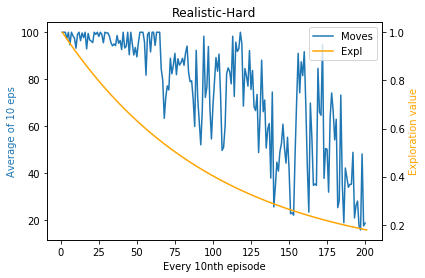

Training took 16.0 minutes and 44.447909355163574 seconds
S1: ['Bedroom', [], ['open door', 'take blanket from bed']]
S2: ['Bedroom', ['blanket'], ['drop blanket', 'open door', 'put blanket on bed']]
S3: ['Bedroom', [], ['open door', 'take blanket']]
S4: ['Bedroom', [], ['close door', 'go east', 'take blanket']]
S5: ['Livingroom', [], ['close door', 'go north', 'go south', 'go west', 'take phone from table']]
S6: ['Toilet', [], ['go north', 'take soap', 'take toilet paper']]
S7: ['Toilet', ['soap'], ['drop soap', 'go north', 'take toilet paper']]
S8: ['Toilet', ['toilet', 'paper'], ['drop toilet paper', 'go north', 'take soap']]
S9: ['Toilet', ['soap', 'toilet', 'paper'], ['drop soap', 'drop toilet paper', 'go north']]
S10: ['Livingroom', ['soap'], ['close door', 'drop soap', 'go north', 'go south', 'go west', 'put soap on table', 'take phone from table']]
S11: ['Livingroom', [], ['close door', 'go north', 'go south', 'go west', 'take phone from table', 'take soap from table']]
S12: ['

In [ ]:
# Load env
game_file = "./Created_Games/Realistic_Game_Hard.ulx"
env, obs, infos = load_game(game_file=game_file)

# Train
train_Q(max_epochs=20, max_eps=100, reset=True, title='Realistic-Hard', manual=True, min_expl=0.05,
        expl_decay_rate=0.001,learning_rate=0.7, neg_reward=10)

# Test
test_Q()

In [ ]:
train_Q(max_epochs=10, max_eps=100, title='Realistic-Hard', min_expl=0.05,
        expl_decay_rate=0.001,learning_rate=0.7, neg_reward=10)
test_Q()